In [2]:
%pylab inline
import numpy as np
import numpy.random as rand
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy import random as rng
import seaborn as sns
import pickle
import argparse
import pandas as pd 
import pickle
sns.set_style('ticks')

from models.npmodels import AENPModel5_ADAM, AENPModel5_ExactLsq_BPAuto, AENPModel5_ExactLsq_FAAuto, AENPModel5
from data_loader.data_generator import MNISTDataGenerator
from trainers.sf_trainer import AESFTrainer
from utils.config import process_config
from utils.logger import LoggerNumpy, Logger

Populating the interactive namespace from numpy and matplotlib


In [1]:
cd /home/lansdell/projects/synthfeedback/

/home/lansdell/projects/synthfeedback


## Plot all on same curve

In [4]:
#idx = 0; # loss
idx = 2; # test loss

#Load BP data from script
model = 'bpself'
fn_in = './experiments/nodepert_ae5_%s/summary/3_autoencoder.npz'%model
#fn_in = './experiments/nodepert_ae5_bp_convparams/summary/3_autoencoder_correctbatch.npz'
with open(fn_in, 'rb') as f:
    data = pickle.load(f)
tags = data['tags']
metrics = data['metrics']
loss_BP = metrics[0,:,:,idx]

#Load FA data
model = 'faself'
fn_in = './experiments/nodepert_ae5_%s/summary/3_autoencoder.npz'%model
#fn_in = './experiments/nodepert_ae5_fa_convparams/summary/3_autoencoder_correctbatch.npz'
with open(fn_in, 'rb') as f:
    data = pickle.load(f)
tags = data['tags']
metrics = data['metrics']
loss_FA = metrics[0,:,:,idx]

#Load Adam data
model = 'adam'
fn_in = './experiments/nodepert_ae5_%s/summary/3_autoencoder_correctbatch.npz'%model
with open(fn_in, 'rb') as f:
    data = pickle.load(f)
tags = data['tags']
metrics = data['metrics']
loss_AD = metrics[0,:,:,idx]

#Load NP data
fn_in = './experiments/nodepert_ae5_sgd_convparams/summary/3_autoencoder_correctbatch.npz'
with open(fn_in, 'rb') as f:
    data = pickle.load(f)
tags = data['tags']
metrics = data['metrics']
loss_NP = metrics[:,0,:,idx].T

In [54]:
metrics.shape

(1, 1, 501, 13)

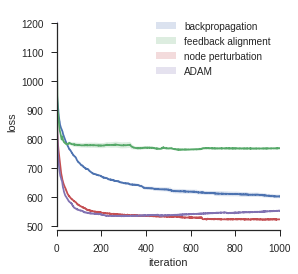

In [5]:
fig,axes = plt.subplots(1,1,figsize=(4,4))

sns.tsplot(loss_BP, ax = axes, color='C0')
sns.tsplot(loss_FA, ax = axes, color='C1')
sns.tsplot(np.squeeze(loss_NP), ax = axes, color='C2')
sns.tsplot(loss_AD, ax = axes, color='C3')

axes.legend(['backpropagation', 'feedback alignment', 'node perturbation', 'ADAM'])
#axes.set_yscale('log')
axes.set_xlabel('iteration');
#axes.set_ylim([450, 1200])
axes.set_ylabel('loss')
sns.despine(trim=True)
#plt.savefig('./figures/3_autoencoder_losses.pdf')

## Images of latent space

In [16]:
def plot_bottleneck(Model = AENPModel5_ADAM, model_name = 'nodepert_ae5_adam', ax = None, cb = None):
    Data = MNISTDataGenerator
    Trainer = AESFTrainer
    config = process_config('./configs/np.json', model_name)
    tf.reset_default_graph()
    model = Model(config)
    data = Data(config)
    sess = tf.Session()
    logger = LoggerNumpy(sess, config, model)
    trainer = Trainer(sess, model, data, config, logger)
    model.load(sess)
    N = 100
    bottlenecks = np.zeros((2, config.batch_size, N))
    ys = np.zeros((config.batch_size, N))
    #Make something to load in an image, evaluate the bottleneck layer with it
    for idx in range(N):
        batch_x, batch_y = next(data.next_batch(config.batch_size))
        feed_dict = {model.x: batch_x, model.y: batch_x, model.is_training: True}
        bottlenecks[:,:,idx] = sess.run(model.bottleneck, feed_dict=feed_dict).T
        ys[:,idx] = np.argmax(batch_y,1)
    if ax:
        ax.scatter(bottlenecks[0,:], bottlenecks[1,:], c = ys, cmap = plt.get_cmap('jet'), alpha = 1, s = 6)
        ax.axis('off')
        if cb:
            ax.colorbar()
    else:
        plt.scatter(bottlenecks[0,:], bottlenecks[1,:], c = ys, cmap = plt.get_cmap('jet'), alpha = 1, s = 6)
        if cb:
            plt.colorbar()

Loading options for exp_name 'nodepert_ae5_adam'
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Loading model checkpoint ./experiments/nodepert_ae5_adam/checkpoint/-0 ...

INFO:tensorflow:Restoring parameters from ./experiments/nodepert_ae5_adam/checkpoint/-0
Model loaded
Loading options for exp_name 'nodepert_ae5_bp_convparams'
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Loading model checkpoint ./experiments/nodepert_ae5_bp_convparams/checkpoint/-0 ...

INFO:tensorflow:Restoring parameters from ./experiments/nodepert_ae5_bp_convparams/checkpoint/-0
Model loaded
Loading options for exp_name 'nodepert_ae5_fa_convparams'
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/trai

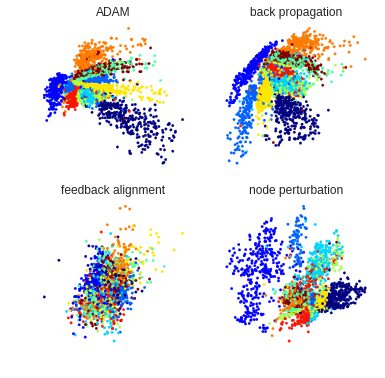

In [17]:
fig, axes = plt.subplots(2,2, figsize = (6,6))
plot_bottleneck(ax = axes[0,0])
plot_bottleneck(ax = axes[0,1], Model = AENPModel5_ExactLsq_BPAuto, model_name = 'nodepert_ae5_bp_convparams')
plot_bottleneck(ax = axes[1,0], Model = AENPModel5_ExactLsq_FAAuto, model_name = 'nodepert_ae5_fa_convparams')
plot_bottleneck(ax = axes[1,1], Model = AENPModel5, model_name = 'nodepert_ae5_sgd_convparams')
axes[0,0].set_title('ADAM')
axes[0,1].set_title('back propagation')
axes[1,0].set_title('feedback alignment')
axes[1,1].set_title('node perturbation')
plt.savefig('./figures/fig_3_autoencoder_latent.pdf')

## Example autoencoded images

In [ ]:
for idx in range(N):
    batch_x, batch_y = next(data.next_batch(config.batch_size))
    feed_dict = {model.x: batch_x, model.y: batch_x, model.is_training: True}
    bottlenecks[:,:,idx] = sess.run(model.bottleneck, feed_dict=feed_dict).T
    ys[:,idx] = np.argmax(batch_y,1)